In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#session.query(Measurement.date).group_by(Measurement.date).distinct().all()
#First attenmpt- code above did not work but keeping incase needed later. 

In [12]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [16]:
dates = session.query(Measurement.date).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()


In [17]:
# Dates from last 12 months conitnued 
dates = dt.datetime.strptime("2017-08-23", "%Y-%m-%d")
numdays = 365
dates_year = [dates - dt.timedelta(days=x) for x in range(0, numdays)]


In [18]:
str_dates = []
for date in dates_year:
    new_date = date.strftime("%Y-%m-%d")
    str_dates.append(new_date)

In [19]:
# Presipitation Data
prcp_results = session.query(func.avg(Measurement.prcp), Measurement.date)\
    .filter(Measurement.date.in_('str_dates'))\
    .group_by(Measurement.date)

In [20]:
prcp_data = []
for res in prcp_results:
    prcp_data.append(res[0])

In [21]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
    #prcp_df = pd.DataFrame([str_dates[::-1], prcp_data[::-1]]).T
    #prcp_df.rename(columns={0: "Date", 1: "Precipitation"}, inplace=True)
    #prcp_df.set_index("Date", inplace=True)
    #prcp_df.head(15)

#this has been unsuccessful in showing precipitation results but keeping for reference for summary statistics work 


In [22]:
session = Session(engine)
conn = engine.connect()
prcp_data_df = pd.read_sql("SELECT date, prcp AS 'precipitation' \
FROM Measurement WHERE date >= '2017-08-23'", conn)
prcp_data_df.head()

,date,precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45


<function matplotlib.pyplot.show(*args, **kw)>

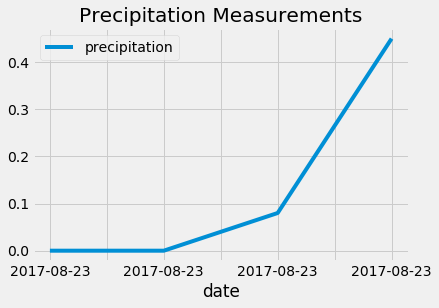

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_data_df.plot(x='date', y='precipitation')
plt.title("Precipitation Measurements")
plt.show

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_data_df.describe()

,precipitation
count,4.0000
mean,0.1325
std,0.2150
min,0.0000
25%,0.0000
50%,0.0400
75%,0.1725
max,0.4500


In [25]:
# Design a query to show how many stations are available in this dataset?
engine.execute('SELECT * FROM station LIMIT 5').fetchall()


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [26]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [27]:
#station_query = engine.execute('SELECT DISTINCT station FROM measurement \
#WHERE date >= '2017-08-23'")
# ERROR: Invalid syntax on date


In [28]:
station_query = session.query(func.count(Station.station))
stations_available = station_query[0]
stations_available

(9)

In [29]:
# There are 9 Number of Stations Available 

In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.prcp))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.prcp).desc())
for station in active_stations:
    print(station)




('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

 #Using station id: USC00519281

station_stats = pd.read_sql("SELECT MAX(tobs) AS ' highest_temperature', \
MIN(tobs) AS 'minimum_temperature', \
AVG(tobs) AS 'average_temperature', \
COUNT(tobs) AS 'count'\
FROM Measurement \
WHERE station = 'USC00519281' AND date >='2017-08-23'", conn)



In [37]:
station_stats

,highest_temperature,minimum_temperature,average_temperature,count
0,None,None,None,0


In [33]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_stats_plot = session.query(Measurement.tobs)\
    .filter(Measurement.date.in_(str_dates))\
    .filter(Measurement.station == 'USC00519281')
stations_stats_data = []
for row in station_stats_plot:
    stations_stats_data.append(row[0])

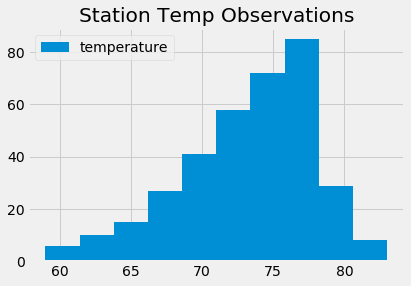

In [34]:
plt.hist(stations_stats_data, label = "temperature")
plt.legend()
plt.title('Station Temp Observations')
plt.show()

## Bonus Challenge Assignment

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [36]:
print(calc_temps('2017-08-23', '2016-08-05'))print(calc_temps('2017-08-23', '2016-08-05'))

SyntaxError: invalid syntax (<ipython-input-36-c3dbbdf1032e>, line 1)